In [1]:
import tensorflow as tf
import os
import collections
import time
import random
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from glob import glob
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.applications.resnet import preprocess_input

In [2]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299,299))
    img = preprocess_input(img)

    return img, image_path


In [3]:
image_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
image_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(image_input, hidden_layer)

In [4]:
with open("../dataset/captions.json") as jf:
    captions = json.loads(jf.read())

#Extract lstm from captions data set.
lstm_info = captions.pop("lstm_labels")
lstm_ranker = lstm_info['labels']
max_vocab_size = lstm_info['vocab_size']
max_caption_size = lstm_info['longest_caption']

#Dataset cleanup
img_name_vector = []
edited_captions = []

image_paths = list(captions.keys())
random.shuffle(image_paths)

for image_path in image_paths:
    captions_image = captions[image_path]
    captions_len = len(captions_image)
    
    for c in captions_image:
        caption = f"<start> {c} <end>"
        edited_captions.append(caption)
    
    img_name_vector.extend([f"{image_path}.jpg"] * captions_len)

train_set_size = round(len(img_name_vector) * 0.9)
test_set_size = len(img_name_vector) - train_set_size

while(img_name_vector[train_set_size] != img_name_vector[train_set_size + 1]):
    train_set_size += 1
    test_set_size -= 1

print(f"TRAIN SET SIZE: {train_set_size}.")
print(f"TEST SET SIZE: {test_set_size}.")

train_captions = edited_captions[:train_set_size]
train_image_name = img_name_vector[:train_set_size]
test_captions = edited_captions[train_set_size:]
test_image_name = img_name_vector[train_set_size:]
for i in range(len(img_name_vector)):
    img_name_vector[i] = f"../dataset/prep_data/{img_name_vector[i]}"

TRAIN SET SIZE: 48918.
TEST SET SIZE: 5434.


<start> He is younger. <end>


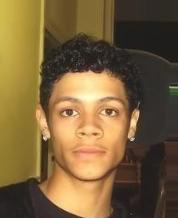

In [5]:
print(train_captions[3])
Image.open(f"../dataset/prep_data/{train_image_name[3]}")

In [ ]:

encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    load_image).batch(16)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

In [6]:
train_set_size = 15000
test_set_size = 2000

while train_image_name[train_set_size] == train_image_name[train_set_size + 1]:
    train_set_size += 1

train_images = train_image_name[:train_set_size]
temp = train_captions[:train_set_size]

index_end = train_set_size + test_set_size

while train_image_name[index_end] == train_image_name[index_end+1]:
    index_end +=1
    
test_images = train_image_name[train_set_size:index_end]
test_captions = train_captions[train_set_size:index_end]
train_captions = temp

In [7]:
print(len(test_images))
print(len(test_captions))
print(len(train_images))
print(len(train_captions))

2003
2003
15001
15001


In [8]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [9]:
top_v = 45

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_v,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

In [10]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [11]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [12]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [13]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [14]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [15]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)
    

(12042, 12042, 2959, 2959)

In [16]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_v + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [17]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [18]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]))

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [19]:
from gru_speaker import GRU_Speaker
from cnn_encoder import CNN_Encoder

In [20]:
decoder = GRU_Decoder(embedding_dim, units, vocab_size)
encoder = CNN_Encoder(embedding_dim)

In [21]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [22]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [23]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [26]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [27]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [32]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.3737
Epoch 1 Batch 100 Loss 0.3894
Epoch 1 Loss 0.372802
Time taken for 1 epoch 45.29149794578552 sec

Epoch 2 Batch 0 Loss 0.3291
Epoch 2 Batch 100 Loss 0.3681
Epoch 2 Loss 0.365620
Time taken for 1 epoch 45.50112223625183 sec

Epoch 3 Batch 0 Loss 0.3238
Epoch 3 Batch 100 Loss 0.3661
Epoch 3 Loss 0.357875
Time taken for 1 epoch 45.83898901939392 sec

Epoch 4 Batch 0 Loss 0.3751
Epoch 4 Batch 100 Loss 0.3284
Epoch 4 Loss 0.349299
Time taken for 1 epoch 45.35869097709656 sec

Epoch 5 Batch 0 Loss 0.3285
Epoch 5 Batch 100 Loss 0.3575
Epoch 5 Loss 0.344178
Time taken for 1 epoch 45.45797109603882 sec

Epoch 6 Batch 0 Loss 0.3161
Epoch 6 Batch 100 Loss 0.3499
Epoch 6 Loss 0.338972
Time taken for 1 epoch 45.8476939201355 sec

Epoch 7 Batch 0 Loss 0.3322
Epoch 7 Batch 100 Loss 0.3358
Epoch 7 Loss 0.334160
Time taken for 1 epoch 45.5770149230957 sec

Epoch 8 Batch 0 Loss 0.3082
Epoch 8 Batch 100 Loss 0.3349
Epoch 8 Loss 0.328058
Time taken for 1 epoch 45.17748284339905

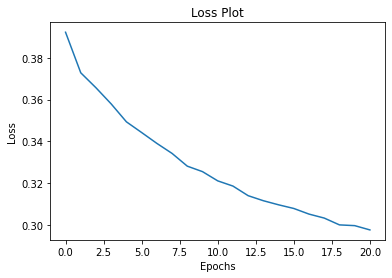

In [33]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [41]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

#         attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [42]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()



Prediction Caption: she has rosy cheeks <end>


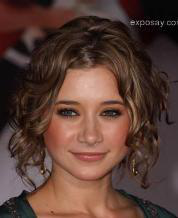

In [54]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[768]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[768]}")

Prediction Caption: she is wearing lipstick <end>


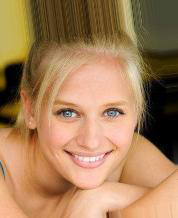

In [55]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[213]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[213]}")

Prediction Caption: she is wearing lipstick <end>


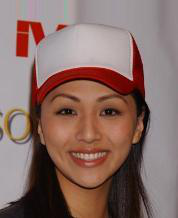

In [56]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[987]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[987]}")

Prediction Caption: she has blond hair <end>


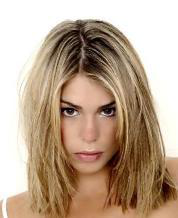

In [57]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[12]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[12]}")

Prediction Caption: she has bangs <end>


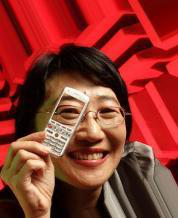

In [58]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[876]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[876]}")

Prediction Caption: he has an oval face <end>


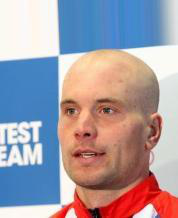

In [59]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[200]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[200]}")

Prediction Caption: he has a double chin <end>


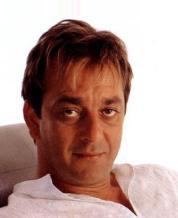

In [60]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[65]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[65]}")